# Phys331 Lab Faraday Effect and Dispersion in Liquids

Here is the python package I used.

In [913]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from scipy.misc import derivative
%matplotlib inline
import matplotlib as mpl

1. Data preprocessing

In [914]:
df = pd.read_csv("fara_green.csv")
print(df.head())
df1 = pd.read_csv("fara_blue.csv")
print(df1.head())
df2 = pd.read_csv("dispersion.csv")
print(df2.head())

   Current  sig_current  Angle_of_extinction  sig_degree
0    -1000            1               1.6610      0.0014
1     -800            1               1.6464      0.0014
2     -601            1               1.6304      0.0014
3     -399            1               1.6086      0.0014
4     -200            1               1.5912      0.0014
   Current  sig_current  Angle_1  Angle_2  Avg_Angle_of_extinction  sig_degree
0   -999.0          1.0    1.705    1.694                    1.700       0.005
1   -799.0          1.0    1.687    1.646                    1.667       0.020
2   -601.0          1.0    1.652    1.635                    1.644       0.009
3   -399.0          1.0    1.609    1.633                    1.621       0.012
4   -200.0          1.0    1.575    1.606                    1.590       0.015
                       Color Element  Wavelength       angle   ang_rad  \
0                   deep red      Cd      643.85  138.166667  2.411463   
1  bright yellow doublet (b)      Hg

2. first approximation of Verdet constant

In [915]:
"""
Define fitting function
"""
def vc(B_field,Verdet_constant,c):
    Angle_of_rotation = Verdet_constant*B_field*0.5+c
    return Angle_of_rotation

def vc_fit(f, x, y):
    popt, pcov = curve_fit(f,x,y, bounds=[(-1000,-100),(1000,100)],p0=[3,0])
    return popt, pcov

convert current to magnetic field stregnth

In [916]:
def app_CtoB(current):
    """
    approximation of B field with B = mu_0 * N * I
    """
    N = 7349/0.5
    mu = 4*(math.pi)*1e-7 # T/amp/m
    return mu*N*current

x_green = df["Current"].div(1000).apply(app_CtoB) # Bfield applied to green polarization
y_green = df["Angle_of_extinction"]
x_blue = df1["Current"].div(1000).apply(app_CtoB) # Bfield applied to blue polarization
y_blue = df1["Avg_Angle_of_extinction"]

In [917]:
green_fit = vc_fit(vc, x_green, y_green)
blue_fit = vc_fit(vc, x_blue, y_blue)
print("parameter={}".format(green_fit[0]))
print("std={}".format(np.sqrt(np.diag(green_fit[1]))))
print("parameter={}".format(blue_fit[0]))
print("std={}".format(np.sqrt(np.diag(blue_fit[1]))))

parameter=[-9.94882568  1.57210983]
std=[0.20698325 0.0012091 ]
parameter=[-12.99173676   1.57350908]
std=[0.19432953 0.00113477]


In [918]:
df4 = pd.DataFrame()
df4["green_fit"] = green_fit[0]
df4["green_fit_std"] = np.sqrt(np.diag(green_fit[1]))
df4["blue_fit"] = green_fit[0]
df4["blue_fit_std"] = np.sqrt(np.diag(green_fit[1]))

2. plot B vs Angle of extinction with fitting curve

<Figure size 432x288 with 0 Axes>

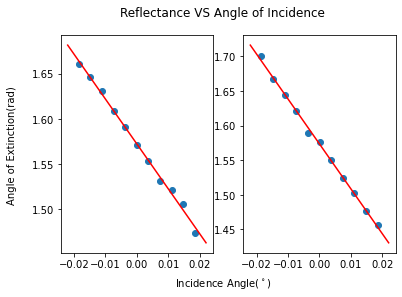

<Figure size 6000x12000 with 0 Axes>

In [919]:
xp = np.linspace(-0.022,0.022,1000)
plt.clf()
fig, axs = plt.subplots(1,2)
plt.figure(figsize=(5,10), dpi=1200)
fig.suptitle("Reflectance VS Angle of Incidence")
fig.text(0.5, 0.01, 'Incidence Angle($^\circ$)', ha='center')
fig.text(0.001, 0.5, 'Angle of Extinction(rad)', va='center', rotation='vertical')
axs[0].scatter(x_green, df["Angle_of_extinction"])
axs[0].plot(xp, vc(xp, green_fit[0][0], green_fit[0][1]),"r")
axs[1].scatter(x_blue, df1["Avg_Angle_of_extinction"])
axs[1].plot(xp, vc(xp, blue_fit[0][0], blue_fit[0][1]),"r")

3. improved B calculation with verdet constant

In [920]:
"""
Define fitting function
"""
def new_vc(currents,slope,c):
    Angle_of_rotation = slope*currents+c
    return Angle_of_rotation

def linear_fit(f, x, y):
    popt, pcov = curve_fit(f,x,y, bounds=[(-1000,-100),(1000,100)],p0=[0,0])
    return popt, pcov

In [921]:
l_green_fit = linear_fit(new_vc, df["Current"].div(1000), df["Angle_of_extinction"])
l_blue_fit = linear_fit(new_vc, df1["Current"].div(1000), df1["Avg_Angle_of_extinction"])
print("parameter={}".format(l_green_fit[0]))
print("std={}".format(np.sqrt(np.diag(l_green_fit[1]))))
print("parameter={}".format(l_blue_fit[0]))
print("std={}".format(np.sqrt(np.diag(l_blue_fit[1]))))

parameter=[-0.09187766  1.57210983]
std=[0.0019115 0.0012091]
parameter=[-0.11997902  1.57350908]
std=[0.00179464 0.00113477]


In [922]:
v_green = l_green_fit[0][0]/8.887e-3
print("improved verdet constant at 546nm:", v_green, "error:",np.sqrt(np.diag(l_green_fit[1]))[1]/8.887e-3)
v_blue = l_blue_fit[0][0]/8.887e-3
print("improved verdet constant at 480nm:", v_blue, "error:",np.sqrt(np.diag(l_blue_fit[1]))[1]/8.887e-3)


improved verdet constant at 546nm: -10.338433821700784 error: 0.13605289088818467
improved verdet constant at 480nm: -13.500509012646257 error: 0.12768907412001415


<Figure size 432x288 with 0 Axes>

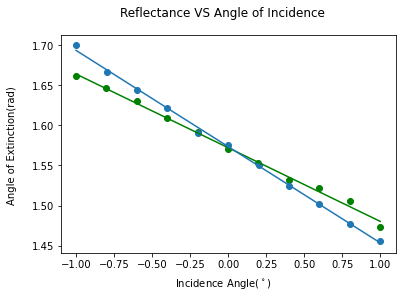

In [923]:
xp = np.linspace(-1,1,1000)
plt.clf()
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.suptitle("Reflectance VS Angle of Incidence")
fig.text(0.5, 0.01, 'Incidence Angle($^\circ$)', ha='center')
fig.text(0.001, 0.5, 'Angle of Extinction(rad)', va='center', rotation='vertical')
ax1.scatter(df["Current"].div(1000), df["Angle_of_extinction"], color="green")
ax1.plot(xp, new_vc(xp, l_green_fit[0][0], l_green_fit[0][1]), color="green")
#axs[0].plot(xp, vc(xp, green_fit[0][0], green_fit[0][1]),"r")
ax1.scatter(df1["Current"].div(1000), df1["Avg_Angle_of_extinction"])
ax1.plot(xp, new_vc(xp, l_blue_fit[0][0], l_blue_fit[0][1]))
#axs[1].plot(xp, vc(xp, blue_fit[0][0], blue_fit[0][1]),"r")

4. dispersion calculation

In [924]:
# snell's equation
def sn(min_dev):
    a = math.pi/3
    up = math.sin((math.pi-min_dev+a)/2)
    down = math.sin((a)/2)
    index_of_refraction = (up/down)
    return index_of_refraction
# 1/lambda^2
def wave(lam):
    return (1/(lam**2))

a = 60
min_dev = 138.16667
up = math.sin(math.radians(min_dev-a)/2)
down = math.sin(math.radians(a)/2)
print(up)
print(down)

0.6304500605822709
0.49999999999999994


In [925]:
df5 = pd.read_csv("dispersion.csv")
df5.head()

,Color,Element,Wavelength,angle,ang_rad,sig_angle,sig_angle_rad
0,deep red,Cd,643.85,138.166667,2.411463,0.333333,0.005818
1,bright yellow doublet (b),Hg,579.07,137.500000,2.399828,0.333333,0.005818
2,bright yellow doublet (a),Hg,576.96,137.500000,2.399828,0.333333,0.005818
3,bright green,Hg,546.08,137.000000,2.391101,0.333333,0.005818
4,turquoise,Cd,508.58,136.333333,2.379466,0.333333,0.005818


In [926]:
df5["n"] = df5["ang_rad"].apply(sn)
df5["wave_sq"] = df5["Wavelength"].apply(wave)
df5.head()

,Color,Element,Wavelength,angle,ang_rad,sig_angle,sig_angle_rad,n,wave_sq
0,deep red,Cd,643.85,138.166667,2.411463,0.333333,0.005818,1.552460,0.000002
1,bright yellow doublet (b),Hg,579.07,137.500000,2.399828,0.333333,0.005818,1.559769,0.000003
2,bright yellow doublet (a),Hg,576.96,137.500000,2.399828,0.333333,0.005818,1.559769,0.000003
3,bright green,Hg,546.08,137.000000,2.391101,0.333333,0.005818,1.565216,0.000003
4,turquoise,Cd,508.58,136.333333,2.379466,0.333333,0.005818,1.572433,0.000004


In [927]:
# wavelegnth linear fit
def dispersion(x, a, b, c):
    t1 = a
    t2 = b/(x**2)
    t3 = c/(x**4)
    return t1 + t2 + t3

def fit(f,x,y):
    popt, pcov = curve_fit(f, x, y, bounds=[(-1,-3e5,-3e15),(2,3e5,3e15)],p0=[0,-2000,-50000])
    return popt, pcov

dispersion_fit = fit(dispersion, df5["Wavelength"], df5["n"])
print("parameter={}".format(dispersion_fit[0]))
print("std={}".format(np.sqrt(np.diag(dispersion_fit[1]))))

parameter=[1.53450548e+00 3.42413833e+03 1.67814438e+09]
std=[1.41084570e-03 6.99870283e+02 8.19251404e+07]


<Figure size 432x288 with 0 Axes>

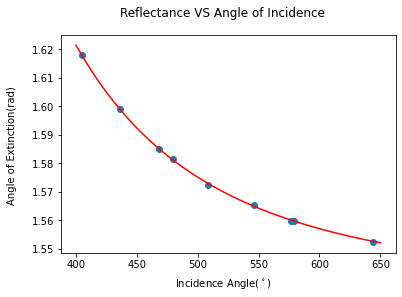

In [928]:
xp = np.linspace(400,650,1000)

plt.clf()
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.suptitle("Reflectance VS Angle of Incidence")
fig.text(0.5, 0.01, 'Incidence Angle($^\circ$)', ha='center')
fig.text(0.001, 0.5, 'Angle of Extinction(rad)', va='center', rotation='vertical')
ax1.plot(xp, dispersion(xp, *dispersion_fit[0]), color="red")
ax1.scatter(df5["Wavelength"],df5["n"])


6. calculate magneto-optical constant

In [932]:
def fit_disp(x):
    return dispersion(x,*dispersion_fit[0])

c = 1.775820e11/(2*299792458)

print(v_green,v_blue)

gama_green = v_green/(derivative(fit_disp, 546, 1e-6)*546)/c
gama_blue = v_blue/(derivative(fit_disp, 480, 1e-6)*480)/c
print(gama_green,gama_blue)

-10.338433821700784 -13.500509012646257
0.3543750182132732 0.2918705857831535
